In [19]:
# Load libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # Visualization

import tensorflow as tf # Deep Learning
import tensorflow_hub as hub # Pre-trained models
 

# Data Preprocessing

In [20]:
df = pd.read_csv('twitter_training.csv', usecols= ['Tweet','Result']) # Read the data only with the columns that we need
df.head() # Show the first 5 rows of the data

,Result,Tweet
0,Positive,im getting on borderlands and i will murder yo...
1,Positive,I am coming to the borders and I will kill you...
2,Positive,im getting on borderlands and i will kill you ...
3,Positive,im coming on borderlands and i will murder you...
4,Positive,im getting on borderlands 2 and i will murder ...


In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74682 entries, 0 to 74681
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Result  74682 non-null  object
 1   Tweet   73996 non-null  object
dtypes: object(2)
memory usage: 1.1+ MB


In [22]:
df.dropna(inplace=True) # Drop the missing values

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 73996 entries, 0 to 74681
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Result  73996 non-null  object
 1   Tweet   73996 non-null  object
dtypes: object(2)
memory usage: 1.7+ MB


In [24]:
df['Result'].unique()

array(['Positive', 'Neutral', 'Negative', 'Irrelevant'], dtype=object)

In [25]:
# Define the condition for irrelevant lines
condition = df['Result'] == 'Irrelevant'

# Get the indices of irrelevant lines
irrelevant_indices = df[condition].index

# Drop the irrelevant lines
df.drop(irrelevant_indices, inplace=True)

In [26]:
df['Result'].unique()

array(['Positive', 'Neutral', 'Negative'], dtype=object)

In [27]:
df['Result'] = df['Result'].apply(lambda x: 0 if x == 'Negative' else (1 if x == 'Neutral' else 2)) # Convert the labels to numerical values

In [28]:
df['Result'].unique()
df.head()

,Result,Tweet
0,2,im getting on borderlands and i will murder yo...
1,2,I am coming to the borders and I will kill you...
2,2,im getting on borderlands and i will kill you ...
3,2,im coming on borderlands and i will murder you...
4,2,im getting on borderlands 2 and i will murder ...


In [29]:
len(df[df['Result'] == 1]) , len(df[df['Result'] == 0]) , len(df[df['Result'] == -1]) # Count the number of each label
# data set is surprisingly balanced

(18108, 22358, 0)

In [30]:
# function that converts a panda dataframe to a tensorflow dataset
def df_to_dataset(dataframe, shuffle=True, batch_size=1024): # Function to convert a dataframe to a dataset
    df = dataframe.copy() # avoid modifying the original dataframe
    labels = df.pop("Result") # Remove the label column from the dataframe
    df = df["Tweet"] # Keep only the description column
    ds = tf.data.Dataset.from_tensor_slices((df, labels)) # Create a tensorflow dataset
    if shuffle: # Shuffle the dataset if needed
        ds = ds.shuffle(buffer_size=len(dataframe))
    ds = ds.batch(batch_size)  # Batch the dataset
    ds = ds.prefetch(tf.data.AUTOTUNE) # automatically tune the number of batches to prefetch based on the current runtime conditions
    return ds

In [31]:
train, val , test = np.split(df.sample(frac=1), [int(.8*len(df)), int(.9*len(df))]) # Split the data into train, validation and test sets with 80%, 10% and 10% of the data 

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [32]:
train_data = df_to_dataset(train) # Convert the train dataframe to a tensorflow dataset
val_data = df_to_dataset(val) # Convert the validation dataframe to a tensorflow dataset
test_data = df_to_dataset(test) # Convert the test dataframe to a tensorflow dataset

# Model

In [33]:
embedding = "https://tfhub.dev/google/nnlm-en-dim50/2" # Load the embedding model
hub_layer = hub.KerasLayer(embedding, input_shape=[], dtype=tf.string, trainable=True) # Create a keras layer with the embedding model

In [34]:
model = tf.keras.Sequential() # Create a sequential model
model.add(hub_layer) # Add the pre-trained layer
model.add(tf.keras.layers.Dense(16, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.01))) # Add a hidden layer with 16 neurons
model.add(tf.keras.layers.Dense(3, activation='softmax')) # Add an output layer with 1 neuron and a sigmoid activation function

In [35]:
model.compile(
    optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.001), # gradient descent algorithm
    loss =  tf.keras.losses.SparseCategoricalCrossentropy(), # loss function
    metrics = ['accuracy']
)

In [36]:
model.evaluate(train_data) # Evaluate the model on the test data

48/48 [==============================] - 0s 3ms/step - loss: 1.3387 - accuracy: 0.3424


[1.3386975526809692, 0.34242063760757446]

In [37]:
model.evaluate(val_data) # Evaluate the model on the validation data

6/6 [==============================] - 0s 3ms/step - loss: 1.3354 - accuracy: 0.3496


[1.3353967666625977, 0.34964004158973694]

In [38]:
history = model.fit(
    train_data,
    validation_data = val_data,
    epochs = 5
)

Epoch 1/5
48/48 [==============================] - 8s 153ms/step - loss: 1.2462 - accuracy: 0.4554 - val_loss: 1.1520 - val_accuracy: 0.5620
Epoch 2/5
48/48 [==============================] - 7s 151ms/step - loss: 1.0544 - accuracy: 0.6411 - val_loss: 0.9583 - val_accuracy: 0.6831
Epoch 3/5
48/48 [==============================] - 7s 152ms/step - loss: 0.8545 - accuracy: 0.7303 - val_loss: 0.7927 - val_accuracy: 0.7400
Epoch 4/5
48/48 [==============================] - 7s 152ms/step - loss: 0.6908 - accuracy: 0.7942 - val_loss: 0.6821 - val_accuracy: 0.7862
Epoch 5/5
48/48 [==============================] - 7s 153ms/step - loss: 0.5729 - accuracy: 0.8428 - val_loss: 0.6076 - val_accuracy: 0.8089


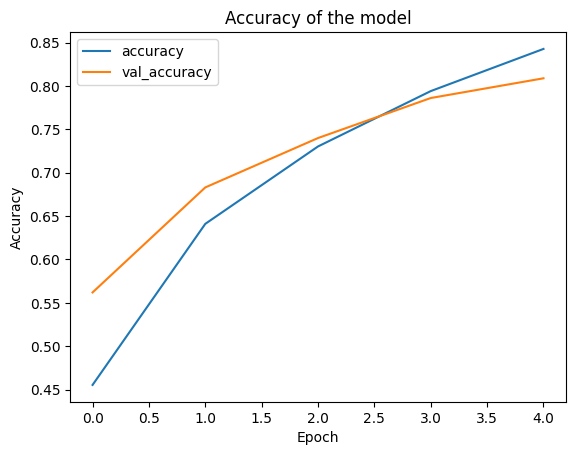

In [39]:
plt.plot(history.history['accuracy'], label='accuracy') # Plot the accuracy of the model on the train data
plt.plot(history.history['val_accuracy'], label = 'val_accuracy') # Plot the accuracy of the model on the validation data
plt.title('Accuracy of the model')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

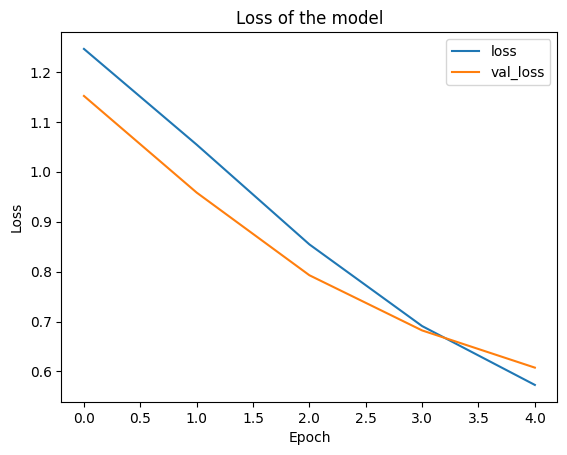

In [40]:
plt.plot(history.history['loss'], label='loss') # Plot the accuracy of the model on the train data
plt.plot(history.history['val_loss'], label = 'val_loss') # Plot the accuracy of the model on the validation data
plt.title('Loss of the model')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [41]:
model.evaluate(test_data) # Evaluate the model on the test data

6/6 [==============================] - 0s 21ms/step - loss: 0.6325 - accuracy: 0.8029


[0.6325132250785828, 0.8028790950775146]